In [548]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

In [549]:
import seaborn as sns
sns.set_palette('Set2')

import matplotlib.pyplot as plt
%matplotlib inline

In [1710]:
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV

In [551]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

In [2415]:
import requests
import json
from datetime import datetime
import time

In [2416]:
import os
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [554]:
from config import yelp_api_key
from config import darksky_api_key

## Set Up

In [568]:
# Import Sales Data
bar_sales_file = 'bar_x_sales_export.csv'
rest_1_file = 'rest_1_dinner_sales.csv'

In [2141]:
# Analysis Dates
start_date = '2017-01-01' # Start Date Inclusive
end_date = '2019-06-01' # End Date Exclusive

In [2142]:
search_business = 'Jupiter Disco'
location = 'Brooklyn, NY'

## Import / Clean / Prep File

In [2143]:
def import_parse(file):

    data = pd.read_csv(file, index_col = 'date', parse_dates=True)
    df = pd.DataFrame(data)
    
    # Rename Column to 'sales'
    df = df.rename(columns={df.columns[0]: 'sales'})
    
    # Drop NaN
    #df = df.query('sales > 0').copy()
    df.fillna(0, inplace=True)
    
    print(f'"{file}" has been imported + parsed. The file has {len(df)} rows.')
    return df

df = import_parse(rest_1_file);

"rest_1_dinner_sales.csv" has been imported + parsed. The file has 889 rows.


In [2144]:
def filter_df(df, start_date, end_date):
    
    return df[(df.index > start_date) & (df.index < end_date)]
    
df = filter_df(df, start_date, end_date)

In [2145]:
def daily_average_matrix_ann(df):
    
    matrix = df.groupby([df.index.dayofweek, df.index.month, df.index.year]).agg({'sales': 'mean'})
    matrix = matrix.rename_axis(['day', 'month', 'year'])
    return matrix.unstack(level=1)

daily_average_matrix_ann(df)

sales                                                  \
month             1           2           3           4           5    
day year                                                               
0   2017  13114.5580  13057.4550  13456.6600  15420.8150  15619.4040   
    2018  10098.7840  15325.0900  12548.1350  14636.8100  18291.7050   
    2019  14084.3925  13828.3650  13939.3850  13946.5600  16315.4975   
1   2017  13402.5860  14033.1175  10172.2475  14505.2125  16682.6960   
    2018  12947.5700  13145.9425  12696.3975  12921.6200  16359.0000   
    2019  10744.8180  14092.9600  13846.2950  16179.8380  16528.1000   
2   2017  13454.2550  13987.3500  13533.9540  14666.2425  16861.9320   
    2018  13389.5180  13188.9900  13296.6500  15260.8800  17667.2340   
    2019  13250.4560  18342.9500  14176.3775  16343.3250  15137.7940   
3   2017  14265.4375  14967.1450  13729.5960  15276.0850  16670.6650   
    2018  13364.3000  15426.3475  14020.2340  15511.2350  17473.5760   
    2019  14354.0560  14821.2075  14426.3725  15997.7475  16693.7960   
4   2017  15365.2000  16154.2575  15387.7400  18623.9575  19017.4725   
    2018  15648.6725  15652.0100  15554.3760  17807.9300  22055.2500   
    2019  16552.3275  16212.2225  15922.3040  16607.2825  21530.8840   
5   2017  17373.3325  16653.0825  17840.6575  19667.3140  20002.4700   
    2018  16401.7675  17866.3850  17624.0680  20923.9000  17995.3650   
    2019  22623.3650  18411.1550  18492.5980  21543.9300  24327.2450   
6   2017  13335.4300  10632.7400  14822.8375  15458.3660  18028.2375   
    2018  14212.3750  11812.9200  14151.9750  16077.8440  17126.2775   
    2019  14322.2850  11145.8400  14410.9540  16448.1125  16313.3400   

                                                                      \
month             6           7           8           9           10   
day year                                                               
0   2017  15633.5500  17677.0800  16662.3000  16909.1325  14552.7500   
    2018  17216.8575  17534.5060  16256.8325  15988.9975  21241.6460   
    2019         NaN         NaN         NaN         NaN         NaN   
1   2017  16493.9275  17217.5900  14951.4600  15740.6050  15490.4700   
    2018  17901.2600  17031.8700  15350.9375  15872.9700  14856.9520   
    2019         NaN         NaN         NaN         NaN         NaN   
2   2017  19167.8950  16988.6350  18485.1660  17022.6025  16328.0075   
    2018  16877.9250  16634.2000  17567.9500  15378.0450  17951.2500   
    2019         NaN         NaN         NaN         NaN         NaN   
3   2017  18556.5380  16449.4375  19084.5960  17664.6325  18379.7050   
    2018  18458.6225  18586.1150  18142.5180  17496.7250  12317.4350   
    2019         NaN         NaN         NaN         NaN         NaN   
4   2017  20566.6220  18752.2725  20013.3825  22247.2960  20541.6400   
    2018  20221.2660  16952.3425  19176.4480  19581.7550  17417.3800   
    2019         NaN         NaN         NaN         NaN         NaN   
5   2017  22854.0900  21847.6520  21851.1525  21502.4160  22722.6350   
    2018  20513.3560  21149.9750  18947.4775  19692.8500  19130.2825   
    2019         NaN         NaN         NaN         NaN         NaN   
6   2017  17394.1575  20702.2360  19243.2350  20489.9300  18160.3160   
    2018  17023.7800  17943.3780  17080.4275  16844.8920  16786.3175   
    2019         NaN         NaN         NaN         NaN         NaN   

                                  
month             11          12  
day year                          
0   2017  13434.9525  10682.9575  
    2018  13030.6625  11405.9500  
    2019         NaN         NaN  
1   2017  14671.3850  14065.7975  
    2018  13332.8125  12669.2100  
    2019         NaN         NaN  
2   2017  14458.0520  14516.3950  
    2018  15508.1100  13369.2325  
    2019         NaN         NaN  
3   2017  12801.6120  15899.8825  
    2018  11564.6680  17304.0925  
    2019         NaN         NaN  
4   2017  16945.6025  16113.0820

## Pull Weather Data

### Latitude + Longitude from Yelp API

In [2146]:
host = 'https://api.yelp.com'
path = '/v3/businesses/search'

search_limit = 10

# Yelp Authorization Header with API Key
headers = {
        'Authorization': 'Bearer {}'.format(yelp_api_key) 
    }

# Build Requests Syntax with Yelp Host and Path and URL Paramaters
# Return JSON response
def request(host, path, url_params=None):
    
    url_params = url_params or {}
    url = '{}{}'.format(host, path)

    response = requests.get(url, headers=headers, params=url_params)
    
    return response.json()

# Build URL Params for the Request and provide the host and path
def search(term, location):
    
    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': search_limit
    }
    
    return request(host, path, url_params=url_params)

# Return Coordinates if Exact Match Found
def yelp_lat_long(business, location):
    
    # Call search function here with business name and location
    response = search(business, location)
    
    # Set state to 'No Match' in case no Yelp match found
    state = 'No Match'
    possible_matches = []
    
    # Check search returns for match wtith business
    for i in range(len(response['businesses'])):

        # If match found:
        if response['businesses'][i]['name'] == business:

            # Local variables to help navigate JSON return
            response_ = response['businesses'][0]
            name_ = response_['name']

            print(f'Coordinates found for {name_}')
            state = 'Match Found'
            #print(response['businesses'][0])
            return response_['coordinates']['latitude'], response_['coordinates']['longitude']

        else:
            
            # If no exact match, append all search returns to list
            possible_matches.append(response['businesses'][i]['name'])
    
    # If no match, show user potential matches
    if state == 'No Match':
        
        print('Exact match not found, did you mean one of the following? \n')
        
        for possible_match in possible_matches:
            print(possible_match)
            
        return None, None

lat, long = yelp_lat_long(search_business, location)
#print(f'Latitude: {lat}\nLongitude: {long}')

Coordinates found for Jupiter Disco


### Darksky API Call

In [2212]:
# Create List of Dates of target Weather Data
def find_dates(start_date, end_date):
    
    list_of_days = []
    daterange = pd.date_range(start_date, end_date)
    for single_date in daterange:
        list_of_days.append(single_date.strftime("%Y-%m-%d"))
    
    return list_of_days

In [2213]:
# Concatenate URL to make API Call
def build_url(api_key, lat, long, day):
    
    _base_url = 'https://api.darksky.net/forecast/'
    _time = 'T20:00:00'
    _url = f'{_base_url}{api_key}/{lat},{long},{day + _time}?America/New_York&exclude=flags'
    return _url

def make_api_call(url):
    
    r = requests.get(url)
    
    return r.json()

In [2500]:
# Try / Except Helper Functionfor Handling JSON API Output
def find_val(dictionary, *keys):

    level = dictionary
    
    for key in keys:
        
        try:
            level = level[key]
            
        except:
            return np.NAN
        
    return level

# Parse API Call Data using Try / Except Helper Function
def parse_data(data):

    time = datetime.fromtimestamp(data['currently']['time']).strftime('%Y-%m-%d')
    
    try:
        precip_max_time = datetime.fromtimestamp(find_val(data, 'daily', 'data', 0, 'precipIntensityMaxTime')).strftime('%I:%M%p')
    
    except:
        precip_max_time = datetime(1900,1,1,5,1).strftime('%I:%M%p')
    
    entry = {'date': time,
             'temperature': float(find_val(data, 'currently', 'temperature')),
             'apparent_temperature': float(find_val(data, 'currently', 'apparentTemperature')),
             'humidity': float(find_val(data, 'currently', 'humidity')),
             'precip_intensity_max': float(find_val(data,'daily','data', 0, 'precipIntensityMax')),
             'precip_type': find_val(data, 'daily', 'data', 0, 'precipType'),
             'summary': find_val(data, 'currently', 'icon'),
             'precip_max_time': precip_max_time}
    
    return entry

In [2501]:
# Create List of Weather Data Dictionaries & Input Target Dates
def weather_call(start_date, end_date, _lat, _long):
    
    weather = []
    list_of_days = find_dates(start_date, end_date)
    
    for day in list_of_days:
        
        data = make_api_call(build_url(darksky_api_key, _lat, _long, day))
    
        weather.append(parse_data(data))
    
    return weather

result = weather_call(start_date, end_date, lat, long)

In [2536]:
# Build DataFrame from List of Dictionaries
def build_weather_df(api_call_results):

    df = pd.DataFrame(api_call_results)

    # Add day of week to DataFrame + Set Index as date
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.weekday
    df['month'] = df['date'].dt.month
    
    df.set_index('date', inplace=True)
    
    df['apparent_temperature'].fillna(method='ffill',inplace=True)
    df['temperature'].fillna(method='ffill',inplace=True)
    df['humidity'].fillna(method='ffill',inplace=True)
    df['precip_type'].fillna(value='none_', inplace=True)
    
    return df

weather_df = build_weather_df(result);

In [2537]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 880 entries, 2017-01-02 to 2019-05-31
Data columns (total 11 columns):
sales                   880 non-null float64
outside                 880 non-null int64
apparent_temperature    880 non-null float64
humidity                876 non-null float64
precip_intensity_max    880 non-null float64
precip_max_time         880 non-null object
precip_type             880 non-null object
summary                 880 non-null object
temperature             880 non-null float64
day_of_week             880 non-null int64
month                   880 non-null int64
dtypes: float64(5), int64(3), object(3)
memory usage: 82.5+ KB


In [2538]:
weather_df.head()
weather_df.tail()

,apparent_temperature,humidity,precip_intensity_max,precip_max_time,precip_type,summary,temperature,day_of_week,month
date,,,,,,,,,
2017-01-01,36.95,0.57,0.0000,05:01AM,none_,clear-night,36.95,6,1
2017-01-02,36.10,0.93,0.0243,03:00PM,rain,rain,39.12,0,1
2017-01-03,43.06,0.95,0.0919,05:00PM,rain,rain,43.06,1,1
2017-01-04,35.51,0.37,0.0180,12:00AM,rain,clear-night,41.16,2,1
2017-01-05,26.84,0.49,0.0000,05:01AM,none_,partly-cloudy-night,31.48,3,1


,apparent_temperature,humidity,precip_intensity_max,precip_max_time,precip_type,summary,temperature,day_of_week,month
date,,,,,,,,,
2019-05-28,69.45,0.83,0.0570,10:00PM,rain,partly-cloudy-day,68.95,1,5
2019-05-29,56.58,0.96,0.3805,06:00PM,rain,rain,56.58,2,5
2019-05-30,63.51,0.93,0.3391,07:00PM,rain,rain,63.14,3,5
2019-05-31,75.80,0.53,0.0223,01:00AM,rain,clear-day,75.80,4,5
2019-06-01,69.24,0.71,0.0002,01:00AM,none_,clear-day,69.24,5,6


In [2539]:
weather_df.to_csv(f'weather_{start_date}_to_{end_date}.csv')
weather_csv_file = f'weather_{start_date}_to_{end_date}.csv'

## Google Trends Data

In [2540]:
rest_1_trends = 'rest_1_google_trends.csv'

In [2541]:
trends_file = rest_1_trends
df_trends = pd.read_csv(trends_file, parse_dates=True)

In [2542]:
def parse_trends(df):
    
    df = df.rename(columns={'Unnamed: 0': 'date', 'Unnamed: 1': 'trends'})
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    return df

df_trends = parse_trends(df_trends)

In [2543]:
df_trends.head()

,trends
date,
2017-01-01,47
2017-01-08,58
2017-01-15,57
2017-01-22,51
2017-01-29,46


### PREPARE DATA

In [2925]:
current_file = rest_1_file

df = filter_df(import_parse(current_file), start_date, end_date)

weather_csv_file = 'weather_2017-01-01_to_2019-06-01.csv'

weather_df_csv = pd.read_csv(weather_csv_file, parse_dates=True, index_col='date')
weather_df_csv['summary'].fillna(value='none', inplace=True)

"rest_1_dinner_sales.csv" has been imported + parsed. The file has 889 rows.


### Merge Sales Data with Weather

In [2926]:
def join_sales_weather(sales_df, weather_df):
    
    df = pd.merge(sales_df, weather_df, how='left', on='date')
    
    return df

df = join_sales_weather(df, weather_df_csv)

data = df.copy(deep=True)

### Check for & Add Historical Closed Dates

In [2927]:
# REST 1 CLOSED DATES
additional_closed_dates = ['2018-12-24', '2017-12-24', '2017-02-05', '2017-03-14', '2018-02-04', '2019-02-03']

# BAR CLOSED DATES
#additional_closed_dates = ['2018-12-24', '2017-12-24', '2017-10-22']

closed_dates = [pd.to_datetime(date) for date in additional_closed_dates]

drop_closed = False

def drop_closed_days(df):

    if drop_closed:
        
        df = df.loc[df['sales'] > 0]
        
    else:

        # CLOSED FEATURE
        cal = calendar()

        # Local list of days with zero sales
        potential_closed_dates = df[df['sales'] == 0].index

        # Enocodes closed days with 1
        df['closed'] = np.where((((df.index.isin(potential_closed_dates)) & \
                                  (df.index.isin(cal.holidays(start_date, end_date)))) | df.index.isin(closed_dates)), 1, 0)

    return df

data = drop_closed_days(data)

### Drop Outliers

In [2928]:
# Drop Outliers 

# Number to Drop for each Day Of Week
max_vals = 2
min_vals = 2

def drop_outliers(df):
    
    print('Starting Observations: ', len(df), '\n')
    
    for d in df['day_of_week'].unique():
        
        # Create List of Rows to Drop
        ## $0 Sales are Not Dropped because typically indicative of Business being Closed
        high_sales = list(df[(df['day_of_week'] == d) & (df['sales'] > 0)]['sales'].nlargest(max_vals).index)
        low_sales = list(df[(df['day_of_week'] == d) & (df['sales'] > 0)]['sales'].nsmallest(min_vals).index)
        
        # Filter Out High / Low Sales
        df = df[~df.index.isin(high_sales)]
        df = df[~df.index.isin(low_sales)]
        
    df['sales'] = np.where(df['sales'] < 0, 0, df['sales'])
    
    print('Ending Observations: ', len(df), '\n')
    
    return df

data = drop_outliers(data)

Starting Observations:  880 

Ending Observations:  852 



### Create Day & Month Clusters

In [2929]:
from sklearn.cluster import KMeans

day_k = 4
mo_k = 4

def create_clusters(df, col, k):
    
    # MAKE DATAFRAME USING CENTRAL TENDENCIES AS FEATURES
    describe = df.groupby(col)['sales'].aggregate(['sum', 'mean', 'median', 'quantile', 'std', 'min', 'max'])
    df = describe.reset_index()
    
    # SCALE TEMPORARY DF
    scaler = MinMaxScaler()
    f = scaler.fit_transform(df)
    
    # INSTANTIATE MODEL
    km = KMeans(n_clusters=k, random_state=0).fit(f)
    
    # GET KMEANS CLUSTER PREDICTIONS
    labels = km.predict(f)
    
    # MAKE SERIES FROM PREDICTIONS
    temp = pd.DataFrame(labels, columns = ['cluster'], index=df.index)
    
    # CONCAT CLUSTERS TO DATAFRAME
    df = pd.concat([df, temp], axis=1)
    
    # CREATE CLUSTER DICTIONARY
    temp_dict = {}
    for i in list(df[col]):
        
        temp_dict[i] = df.loc[df[col] == i, 'cluster'].iloc[0]
    
    return temp_dict

day_dict = create_clusters(data, 'day_of_week', day_k)
month_dict = create_clusters(data, 'month', mo_k)

In [2913]:
# Add Clusters to DataFrame to use as Features
def add_clusters(df):
    
    df['day_cluster'] = df['day_of_week'].apply(lambda x: day_dict[x]).astype('category')
    df['month_cluster'] = df['month'].apply(lambda x: month_dict[x]).astype('category')
    
    return df

dfx = add_clusters(data)

In [2914]:
# Print Clusters
print('Day Clusters: ', day_dict, '\n', 'Total Clusters: ', len(set(day_dict.values())), '\n')
print('Month Clusters: ', month_dict, '\n', 'Total Clusters: ', len(set(month_dict.values())))

Day Clusters:  {0: 2, 1: 2, 2: 3, 3: 1, 4: 0, 5: 0, 6: 1} 
 Total Clusters:  4 

Month Clusters:  {1: 2, 2: 2, 3: 2, 4: 3, 5: 3, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1} 
 Total Clusters:  4


## Feature Engineering

### Add Weather Features

In [2915]:
hours_start = '06:00PM'
hours_end = '11:30PM'

hs_dt = datetime.strptime(hours_start, "%I:%M%p")
he_dt = datetime.strptime(hours_end, "%I:%M%p")

def between_time(check_time):
        
    if hs_dt <= datetime.strptime(check_time, "%I:%M%p") <= he_dt:

        return 1

    else:

        return 0

In [2916]:
add_weather = True
temp_delta_window = 1

def add_weather_features(df):
    
    avg_precip_max_intensity = np.mean([pmax for pmax in df.precip_intensity_max if pmax != 0])
    
    if add_weather:

        # Create Weather Categories
        df['weather'] = pd.cut(df['apparent_temperature'], 3, labels=['cold', 'warm', 'hot']).astype('category')
        
        # POOR WEATHER FEATURE
        df['precip_while_open'] = df['precip_max_time'].apply(lambda x: between_time(x))
        
        df['strong_precip'] = np.where(df['precip_intensity_max'].apply(lambda x: x > avg_precip_max_intensity), 1, 0)
    
        # DROP FEATURES
        features_to_drop = ['apparent_temperature', 'temperature', 'precip_intensity_max', 'precip_max_time', 'precip_type', 'summary']
        df.drop(features_to_drop, axis=1, inplace=True)
        
    return df

dfx = add_weather_features(dfx)

### Add Calendar Features

In [2917]:
def add_cal_features(df):
    
        cal = calendar()
        
        # THREE DAY WEEKEND FEATURE
        sunday_three_days = [date + pd.DateOffset(-1) for date in cal.holidays(start_date, end_date) if date.dayofweek == 0]
        df['sunday_three_day'] = np.where(df.index.isin(sunday_three_days), 1, 0)

        #monday_three_days = [date for date in cal.holidays(start_date, end_date) if date.dayofweek == 0]
        #df['monday_three_day'] = np.where(df.index.isin(monday_three_days), 1, 0)
        
        return df
    
dfx = add_cal_features(dfx)

### Add Dummies

In [2918]:
dfx.columns

Index(['sales', 'outside', 'humidity', 'day_of_week', 'month', 'closed',
       'day_cluster', 'month_cluster', 'weather', 'precip_while_open',
       'strong_precip', 'sunday_three_day'],
      dtype='object')

In [2919]:
def add_dummies(df):
    
    df = pd.get_dummies(data=df, columns=['weather', 'day_cluster', 'month_cluster'])
    
    return df

dfx = add_dummies(dfx)

### Add Interactions

In [2922]:
apply_interactions = True

def add_interactions(df):
    
    if apply_interactions:
        
        for d in [col for col in df.columns if col.startswith('day_cluster')]:
            
            for m in [col for col in df.columns if col.startswith('month_cluster')]:
                
                col_name = d + '_X_' + m
                
                df[col_name] = df[d] * df[m]
                
            df.drop([d], axis=1, inplace=True)
        
        df.drop([col for col in df.columns if col.startswith('month_cluster')], axis=1, inplace=True)
                
        return df
    
    else:
        
        return df
    
dfx = add_interactions(dfx)

In [2923]:
apply_weather_interactions = True

def add_weather_interactions(df):
    
    if apply_weather_interactions:
                
        for w in [col for col in df.columns if col.startswith('weather')]:
            
            col_name_3 = w + '_X_' + 'outside'
            df[col_name_3] = df[w] * df['outside']
            
        return df
    
    else:
        
        return df

dfx = add_weather_interactions(dfx)

In [2924]:
def feature_selection(df):
    
    # Feature Selection / Drop unnecessary or correlated columns
    cols_to_drop = []
    
    df = df.drop(cols_to_drop, axis=1)
    
    return df

dfx = feature_selection(dfx)

In [2930]:
def feature_engineering(df):
    
    # Add day & Month Clusters // Dicts with data held in Global Variable
    df = add_clusters(df)
    
    # Add Engineered Features for Weather & Calendar
    df = add_weather_features(df)
    df = add_cal_features(df)
    
    # Create Dummies
    df = add_dummies(df)
    
    # Add Interactions
    df = add_interactions(df)
    df = add_weather_interactions(df)
    
    # Drop Selected Columns
    df = feature_selection(df)
    
    return df

dfx = feature_engineering(data)

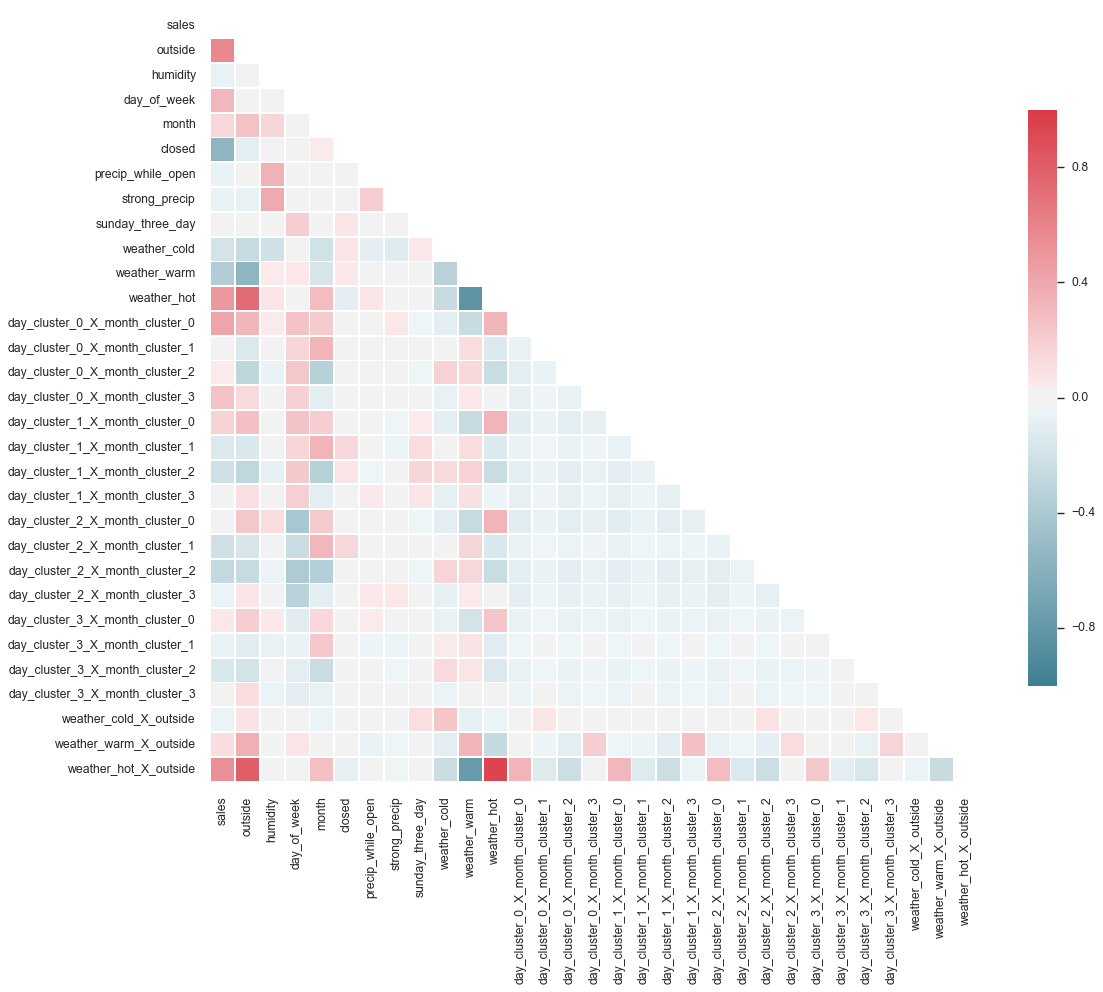

In [2931]:
def corr_chart(df):
    
    corr = dfx.corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    sns.set_style('whitegrid')
    f, ax = plt.subplots(figsize=(16, 12))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.75, annot=False, cbar_kws={"shrink": .75});
    
corr_chart(dfx)

## Test / Train / Split

In [2932]:
def train_test_split(df):
    
    # Separate Target & Features
    y = df['sales']
    features = df.drop(['sales'], axis=1)
    
    # Test / Train / Split
    train_date_start = '2017-01-01'
    train_date_end = '2018-12-31'
    
    X_train = features[train_date_start:train_date_end]
    X_test = features[pd.to_datetime(train_date_end) + pd.DateOffset(1): ]
    
    y_train = y[train_date_start:train_date_end]
    y_test = y[pd.to_datetime(train_date_end) + pd.DateOffset(1): ]
    
    print('Train set: ', len(X_train))
    print('Test set: ', len(X_test))
    
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = train_test_split(dfx)

Train set:  707
Test set:  145


In [2966]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

X_new = SelectKBest(mutual_info_regression, k=30).fit_transform(X_train, y_train)
X_test_new = SelectKBest(mutual_info_regression, k=30).fit_transform(X_test, y_test)

In [2967]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class FeatureEngineer(BaseEstimator, TransformerMixin):
    
    def __init__(self, col):
        self.col = col
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.col]
    
    
cluster = Pipeline([
                    ('selector', FeatureEngineer(col='day_of_week')),
                    
])

### Linear Regression

In [2968]:
def linear_regression_model(X_train, y_train):
    
    lr = LinearRegression(fit_intercept=True)
    lr_rgr = lr.fit(X_train, y_train)
    
    return lr_rgr

In [2969]:
lr_rgr = linear_regression_model(X_new, y_train)

In [2970]:
def rgr_score(rgr, X_train, y_train, X_test, y_test):
    
    train_score = rgr.score(X_train, y_train)
    test_score = rgr.score(X_test, y_test)
    
    y_pred = rgr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print('Train R-Squared:  ', train_score)
    print('Test R-Squared:  ', test_score, '\n')
    
    print('Root Mean Squared Error: ', rmse, '\n')
    
    print('Intercept:  ', rgr.intercept_, '\n')
    print('Coefficients:  \n')
    
    for index, col_name in enumerate(X_test.columns):
        print(col_name, ' --> ', rgr.coef_[index])
        
rgr_score(lr_rgr, X_new, y_train, X_test_new, y_test)

Train R-Squared:   0.7832611452060738
Test R-Squared:   0.7604362826639701 

Root Mean Squared Error:  1529.2762259351948 

Intercept:   14919.526773655673 

Coefficients:  



AttributeError: 'numpy.ndarray' object has no attribute 'columns'

### Prediction Function

In [2843]:
def predict_df(clf, X_train, date_1, date_2):
    
    lat, long = yelp_lat_long(search_business, location)
    
    weather_df = build_weather_df(weather_call(date_1, date_2, lat, long))
    weather_df['outside'] = 1
    
    df = add_weather_interactions(add_interactions(add_dummies(add_cal_features(add_weather_features(add_clusters((weather_df)))))))
    
    missing_cols = set(X_train.columns) - set(df.columns)
    
    for c in missing_cols:
        df[c] = 0
        
    test_df = pd.DataFrame(data=X_scaler.transform(df), columns=df.columns)
    
    pred_array = pd.DataFrame(clf.predict(test_df), index=df.index, columns=['sales'])
    pred_df = df[df.columns[(df != 0).any()]]
    
    return pd.concat([pred_array, pred_df], axis=1)

In [2805]:
this_week = predict_df(lr_rgr, X_train, pd.datetime.now().date() + pd.DateOffset(-temp_delta_window), pd.datetime.now().date() + pd.DateOffset(6))
this_week[temp_delta_window - 1:]

Coordinates found for Jupiter Disco


,sales,humidity,outside,precip_while_open,strong_precip,w_cold,w_warm,w_hot,dayclus_0_X_moclus_0,dayclus_1_X_moclus_0,dayclus_2_X_moclus_0,dayclus_3_X_moclus_0,w_cold_X_outside,w_warm_X_outside,w_hot_X_outside
date,,,,,,,,,,,,,,,
2019-06-11,-1.780391e+15,0.30,1,0,1,0,1,0,0,0,1,0,0,1,0
2019-06-12,-6.718938e+14,0.54,1,1,0,1,0,0,0,0,0,1,1,0,0
2019-06-13,-6.730378e+14,0.83,1,0,1,1,0,0,0,1,0,0,1,0,0
2019-06-14,-1.932988e+12,0.49,1,0,0,1,0,0,1,0,0,0,1,0,0
2019-06-15,-1.111180e+15,0.44,1,0,0,0,1,0,1,0,0,0,0,1,0
2019-06-16,-1.781220e+15,0.51,1,1,0,0,0,1,0,1,0,0,0,0,1
2019-06-17,-1.781733e+15,0.64,1,0,1,0,0,1,0,0,1,0,0,0,1
2019-06-18,-1.781693e+15,0.63,1,0,0,0,1,0,0,0,1,0,0,1,0


## Lasso

In [2936]:
def lasso_model(X_train, y_train):

    lassoReg = Lasso(fit_intercept=True, alpha=0.05)
    lasso_rgr = lassoReg.fit(X_train,y_train)

    return lasso_rgr

lasso_rgr = lasso_model(X_train, y_train)

In [2937]:
rgr_score(lasso_rgr, X_train, y_train, X_test, y_test)

Train R-Squared:   0.7832607934935434
Test R-Squared:   0.7604039042178199 

Root Mean Squared Error:  1529.3795677841053 

Intercept:   14519.707953619223 

Coefficients:  

outside  -->  3295.7078909539737
humidity  -->  -1423.0603530201497
day_of_week  -->  142.02137211064627
month  -->  58.771995710912684
closed  -->  -14357.58147681177
precip_while_open  -->  -543.4480185863679
strong_precip  -->  -133.05675871876147
sunday_three_day  -->  910.5724876458908
weather_cold  -->  -557.703917771921
weather_warm  -->  0.0
weather_hot  -->  149.7455210708582
day_cluster_0_X_month_cluster_0  -->  2594.8740935883716
day_cluster_0_X_month_cluster_1  -->  1527.7073347655792
day_cluster_0_X_month_cluster_2  -->  2365.916277610496
day_cluster_0_X_month_cluster_3  -->  3094.2856366879055
day_cluster_1_X_month_cluster_0  -->  191.83322806508053
day_cluster_1_X_month_cluster_1  -->  68.72304224916682
day_cluster_1_X_month_cluster_2  -->  138.7035045325643
day_cluster_1_X_month_cluster_3  -->  230

In [2808]:
this_week = predict_df(lasso_rgr, X_train, pd.datetime.now().date() + pd.DateOffset(-temp_delta_window), pd.datetime.now().date() + pd.DateOffset(6))
this_week[temp_delta_window-1:]

Coordinates found for Jupiter Disco


,sales,humidity,outside,precip_while_open,strong_precip,w_cold,w_warm,w_hot,dayclus_0_X_moclus_0,dayclus_1_X_moclus_0,dayclus_2_X_moclus_0,dayclus_3_X_moclus_0,w_cold_X_outside,w_warm_X_outside,w_hot_X_outside
date,,,,,,,,,,,,,,,
2019-06-11,16264.822893,0.30,1,0,1,0,1,0,0,0,1,0,0,1,0
2019-06-12,8013.996948,0.54,1,1,0,1,0,0,0,0,0,1,1,0,0
2019-06-13,23350.382201,0.83,1,0,1,1,0,0,0,1,0,0,1,0,0
2019-06-14,20032.234495,0.49,1,0,0,1,0,0,1,0,0,0,1,0,0
2019-06-15,15428.792660,0.44,1,0,0,0,1,0,1,0,0,0,0,1,0
2019-06-16,4723.367586,0.51,1,1,0,0,0,1,0,1,0,0,0,0,1
2019-06-17,17996.108487,0.64,1,0,1,0,0,1,0,0,1,0,0,0,1
2019-06-18,17902.103352,0.63,1,0,0,0,1,0,0,0,1,0,0,1,0


### Random Forest Regression

In [2809]:
def rf_regression_model(X_train, y_train):
    
    rfr = RandomForestRegressor(max_depth= 60, 
                                max_features= 0.5, 
                                min_impurity_decrease= 0.0001, 
                                n_estimators= 1000)
    rfr_rgr = rfr.fit(X_train, y_train)
    
    return rfr_rgr

In [2810]:
rfr_rgr = rf_regression_model(X_train, y_train)

In [2623]:
def rfr_score(rgr, X_test, y_test):
    
    train_score = rgr.score(X_train, y_train)
    test_score = rgr.score(X_test, y_test)
    
    print('Train R-Squared:  ', train_score)
    print('Test R-Squared:  ', test_score, '\n')
        
rfr_score(rfr_rgr, X_test, y_test) 

Train R-Squared:   0.9433899705499915
Test R-Squared:   0.6990519087103608 



### Random Forest Regression Prediction

In [1978]:
this_week = predict_df(rfr_rgr, X_train, pd.datetime.now().date() + pd.DateOffset(-temp_delta_window), pd.datetime.now().date() + pd.DateOffset(6))
this_week[temp_delta_window:]

Coordinates found for Jupiter Disco


,sales,outside,precip_prob,poor_weather,w_very_cold,w_warm,w_hot,w_very_hot,dayclus_0_X_moclus_0,dayclus_1_X_moclus_0,dayclus_2_X_moclus_0,dayclus_3_X_moclus_0,w_very_cold_X_outside,w_warm_X_outside,w_hot_X_outside,w_very_hot_X_outside
date,,,,,,,,,,,,,,,,
2019-06-12,14780.998096,1,0.01,0,1,0,0,0,0,0,0,1,1,0,0,0
2019-06-13,15364.158610,1,0.14,0,1,0,0,0,0,1,0,0,1,0,0,0
2019-06-14,19788.398134,1,0.00,0,1,0,0,0,1,0,0,0,1,0,0,0
2019-06-15,19839.717036,1,0.00,0,0,1,0,0,1,0,0,0,0,1,0,0
2019-06-16,18681.627195,1,0.03,0,0,0,0,1,0,1,0,0,0,0,0,1
2019-06-17,15892.059180,1,0.06,0,0,0,0,1,0,0,1,0,0,0,0,1
2019-06-18,15096.010907,1,0.24,1,0,0,1,0,0,0,1,0,0,0,1,0


### Grid Search Helper Function

In [187]:
def run_grid_search(rgr, params, X_train, y_train):
    
    cv = 5
    n_jobs = -1
    scoring = 'r2'
    
    grid = GridSearchCV(rgr, params, cv=cv, n_jobs=n_jobs, scoring=scoring, verbose=10)
    grid = grid.fit(X_train, y_train)
    
    best_grid_rgr = grid.best_estimator_
    
    print('Grid Search: ', rgr.__class__.__name__, '\n')
    print('Grid Search Best Score: ', grid.best_score_)
    print('Grid Search Best Params: ', grid.best_params_)
    print('Grid Search Best Estimator: ', grid.best_estimator_)

    return best_grid_rgr


In [188]:
params = {
          'n_estimators': [500, 750, 1000, 1250],
          'max_depth': [30, 40, 50, 60, 70, 80],
          'min_impurity_decrease': [0.001, 0.0001],
          'max_features': ['auto', 0.25, 0.50, 0.75]
        }

best_grid_rgr = run_grid_search(rfr_rgr, params, X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

Grid Search:  RandomForestRegressor 

Grid Search Best Score:  0.7686553131362353
Grid Search Best Params:  {'max_depth': 60, 'max_features': 0.5, 'min_impurity_decrease': 0.0001, 'n_estimators': 1000}
Grid Search Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=60,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0001, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=60,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0001, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [189]:
rfr_rgr.get_params().keys()

dict_keys(['bootstrap', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [2624]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2625]:
dfx.head()

,sales,outside,humidity,closed,precip_while_open,strong_precip,sunday_three_day,w_very_cold,w_cold,w_warm,...,dayclus_2_X_moclus_3,dayclus_3_X_moclus_0,dayclus_3_X_moclus_1,dayclus_3_X_moclus_2,dayclus_3_X_moclus_3,w_very_cold_X_outside,w_cold_X_outside,w_warm_X_outside,w_hot_X_outside,w_very_hot_X_outside
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,12814.84,0,0.93,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2017-01-03,12442.11,0,0.95,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2017-01-04,11877.64,0,0.37,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2017-01-05,14057.79,0,0.49,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-06,14531.97,0,0.49,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [2626]:
f = ''

for c in dfx.columns:
    
    f += c + '+'
    
x = f[6:-1]

In [2627]:
f='sales~' + x

model = ols(formula=f, data=dfx).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     102.3
Date:                Wed, 12 Jun 2019   Prob (F-statistic):          7.98e-250
Time:                        20:14:31   Log-Likelihood:                -7471.4
No. Observations:                 852   AIC:                         1.500e+04
Df Residuals:                     822   BIC:                         1.515e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.233e+04    238.387     51.724      0.000    1.19e+04    1.28e+04
outside                1109.6700    298.218      3.721      0.000     524.312    1695.028
humidity              -1341.0514    363.895     -3.685      0.000   -2055.325    -626.778
closed                -1.434e+04    496.799    -28.857      0.000   -1.53e+04   -1.34e+04
precip_while_open      -373.0604    178.643     -2.088      0.037    -723.710     -22.411
strong_precip          -192.5754    167.455     -1.150      0.250    -521.265     136.115
sunday_three_day       1599.8422    434.950      3.678      0.000     746.099    2453.585
w_very_cold            2127.3577    352.112      6.042      0.000    1436.214    2818.502
w_cold                 2459.9216    211.473     11.632      0.000    2044.832    2875.012
w_warm                 2707.3103    187.307     14.454      0.000    2339.655    3074.966
w_hot                  3001.5835    263.134     11.407      0.000    2485.090    3518.077
w_very_hot             2034.2452    693.185      2.935      0.003     673.624    3394.866
dayclus_0_X_moclus_0   3183.1498    211.259     15.068      0.000    2768.480    3597.820
dayclus_0_X_moclus_1   2286.6808    274.297      8.337      0.000    1748.276    2825.085
dayclus_0_X_moclus_2   2675.1268    205.651     13.008      0.000    2271.464    3078.790
dayclus_0_X_moclus_3   3489.9943    236.371     14.765      0.000    3026.032    3953.957
dayclus_1_X_moclus_0    800.4450    210.948      3.795      0.000     386.384    1214.506
dayclus_1_X_moclus_1    799.6611    278.039      2.876      0.004     253.911    1345.412
dayclus_1_X_moclus_2    295.5668    206.781      1.429      0.153    -110.314     701.448
dayclus_1_X_moclus_3    412.4146    227.998      1.809      0.071     -35.112     859.942
dayclus_2_X_moclus_0   -606.7411    202.846     -2.991      0.003   -1004.899    -208.584
dayclus_2_X_moclus_1     75.6677    288.832      0.262      0.793    -491.267     642.603
dayclus_2_X_moclus_2   -449.7575    207.069     -2.172      0.030    -856.203     -43.312
dayclus_2_X_moclus_3   -340.0391    221.797     -1.533      0.126    -775.395      95.317
dayclus_3_X_moclus_0     30.6408    272.878      0.112      0.911    -504.979     566.261
dayclus_3_X_moclus_1    300.6222    388.197      0.774      0.439    -461.352    1062.596
dayclus_3_X_moclus_2   -264.7739    269.615     -0.982      0.326    -793.988     264.440
dayclus_3_X_moclus_3   -358.2400    306.427     -1.169      0.243    -959.712     243.232
w_very_cold_X_outside -2280.3461   1020.798     -2.234      0.026   -4284.024    -276.669
w_cold_X_outside      -1693.6080    817.364     -2.072      0.039   -3297.974     -89.242
w_warm_X_outside        196.6332    389.305      0.505      0.614    -567.515     960.781
w_hot_X_outside        